In [31]:
import pandas as pd
import yfinance as yf
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')
from IPython.display import Image
import os
import sys

## Automated portfolio system
### Currently generates a equally weighted portfolio that has increased by 57.28% since the completion of this project.
### And enhances the portfolio with optimized weights, outputting the final portfolio that has increased by 70.59% since the completion of this project.
### -----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


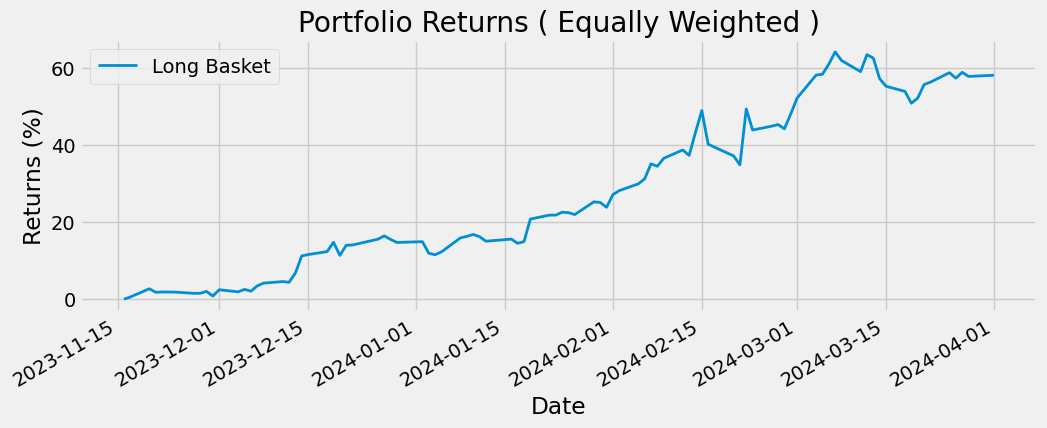

Portfolio 1: Returns from Project Completion to Current Date
Date
2023-11-16     0.000000
2023-11-17     0.553123
2023-11-20     2.694560
2023-11-21     1.782077
2023-11-22     1.858214
                ...    
2024-03-25    58.803296
2024-03-26    57.378833
2024-03-27    58.897137
2024-03-28    57.828228
2024-04-01    58.145768
Length: 92, dtype: float64
Avegare Weekly Portfolio Returns from Project Completion to Current Date (19 weeks): 
3.0603035750979055


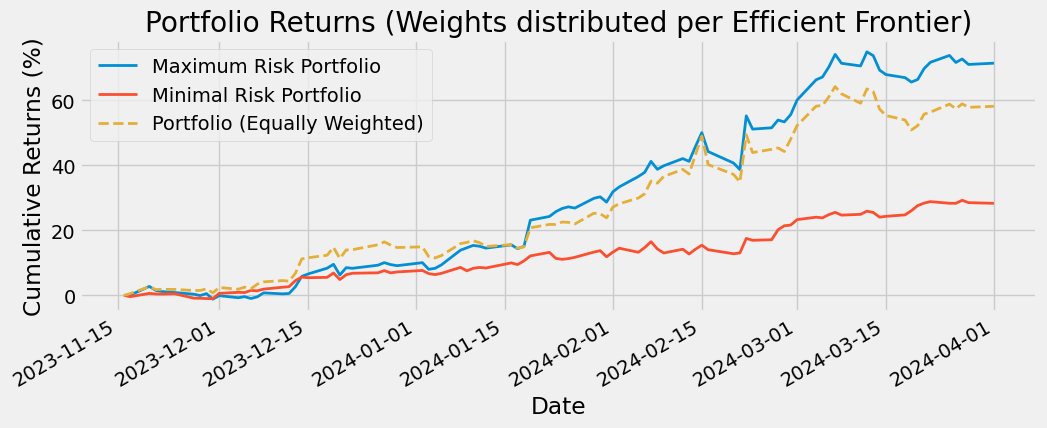

Max Risk Portfolio: Returns from Project Completion to Current Date
Date
2023-11-16     0.000000
2023-11-17     0.110744
2023-11-20     2.760303
2023-11-21     1.547251
2023-11-22     1.193113
                ...    
2024-03-25    73.774103
2024-03-26    71.620688
2024-03-27    72.679326
2024-03-28    71.003531
2024-04-01    71.401171
Length: 92, dtype: float64
Min Risk Portfolio: Returns from Project Completion to Current Date
Date
2023-11-16     0.000000
2023-11-17    -0.393507
2023-11-20     0.612144
2023-11-21     0.452038
2023-11-22     0.404814
                ...    
2024-03-25    28.331459
2024-03-26    28.308445
2024-03-27    29.242735
2024-03-28    28.518317
2024-04-01    28.307222
Length: 92, dtype: float64
Avegare Weekly Max Risk Portfolio Returns from Project Completion to Current Date (19 weeks): 
3.7579563819766473
Avegare Weekly Min Risk Portfolio Returns from Project Completion to Current Date (19 weeks): 
1.4898537995653485


In [38]:
# Graphs of portfolio performance
display(Image(filename=os.getcwd() + '\\port1.png'))
print("Portfolio 1: Returns from Project Completion to Current Date")
print (portfolio_returns)
print (f"Avegare Weekly Portfolio Returns from Project Completion to Current Date ({weeks} weeks): ")
print (portfolio_returns[-1]/weeks)
display(Image(filename=os.getcwd() + '\\all_ports.png'))
print ("Max Risk Portfolio: Returns from Project Completion to Current Date")
print (cumulative_returns_maximum_risk)
print ("Min Risk Portfolio: Returns from Project Completion to Current Date")
print (cumulative_returns_minimal_risk)

print (f"Avegare Weekly Max Risk Portfolio Returns from Project Completion to Current Date ({weeks} weeks): ")
print (cumulative_returns_maximum_risk[-1]/weeks)

print (f"Avegare Weekly Min Risk Portfolio Returns from Project Completion to Current Date ({weeks} weeks): ")
print (cumulative_returns_minimal_risk[-1]/weeks)


#### Project premise is to use an alpha generator to automatically generate a portfolio that will maximize our gains with respect to risk-taken.
#### An alpha generator is any security that, when added by an investor to an existing portfolio of assets, generates excess returns or returns higher than a pre-selected benchmark without additional risk.
#### I am using the price momentum alpha generator because its calculations are free and easily accessible through yfinance library.

### The SP500 is our benchmark, we retrieve its updated 500 stocks directly from the daily-updated csv from the State Street Global Advisors website.

In [2]:
# Get the list of S&P 500 constituents
sp500_tickers = pd.read_excel(
    "https://www.ssga.com/us/en/intermediary/etfs/library-content/products/fund-data/etfs/us/holdings-daily-us-en-spy.xlsx",
    header=4).Ticker.dropna().to_list()

# Retrieve historical data
df = yf.download(sp500_tickers, period='10y')
sp500 = df['Adj Close'].dropna(how='all', axis=1)

[*********************100%%**********************]  505 of 505 completed

4 Failed downloads:
['SOLVW', '-', 'BRK.B']: Exception('%ticker%: No data found, symbol may be delisted')
['BF.B']: Exception('%ticker%: No price data found, symbol may be delisted (period=10y)')


In [3]:
# Gets the last date of dataset
# This is our most current price for eah asset, just as a refernce of the prices we are using.
sp500.tail(1) 

Ticker,A,AAL,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,ADI,...,WY,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2024-04-01,145.559998,15.41,170.029999,180.759995,163.369995,112.089996,92.309998,339.170013,502.089996,196.619995,...,35.560001,106.559998,53.279999,116.989998,32.25,128.639999,140.470001,129.75,301.0,167.020004


In [4]:
# Changing the time period and lag will affect the range of the alortithm
time_period = 1260  # 5 years of trading days. (252 trading days per year)
lag = 20 # lag of 20 trading days (1 month)


## Momentum Factors
####  Calculates each sp500 stock scores based on factors.

In [5]:
#how_many_days_back = 0 for current, 1260 for 5 years.

def calculate_momentum_factors(how_many_days_back):
# Define the start and end points for the data slice
    start_time = how_many_days_back+ time_period + lag # start at start_time, increase by time_period, include lag
    most_current_time = how_many_days_back+ lag # only difference is the time_period is not included, so we get slice of time period exactly
    
    lagged_closed_price = sp500[-start_time: -most_current_time ] #slice the dataframe to get 5 years
    rolling_mean_price = lagged_closed_price.rolling(window= time_period-251).mean().dropna(how='all') # get the rolling mean price window for 1 year

    # Calculate the 52-week trend
    slope_info = pd.DataFrame(index=sp500.columns)
    for i in range(1, lag + 1): 
        slope_info[i] = rolling_mean_price.apply(
            lambda x: np.polyfit(
                np.arange(len(x[-i - 252: -i])),
                                  x[-i - 252: -i], 1)[0] if x[-i - 252: -i].notna().all() else np.nan) 
    
    _52_week_trend = slope_info.mean(axis=1) # This is our first factor, the 52 week trend line which is the average of the slopes of the 52 week trend line


    # percent above 260 day low is the current price - 260 day low / 260 day low * 100, its used to measure the strength of the current price
    percent_above_260 = (lagged_closed_price - lagged_closed_price.rolling(window=260).min()) / lagged_closed_price.rolling(window=260).min() * 100
    percent_above_260 = percent_above_260.dropna(how='all').mean()

    # Rolling 4 week mean - rolling 52 week mean / rolling 52 week mean * 100, the oscillator is a measure of momentum
    oscillator = (lagged_closed_price.rolling(window=4*5).mean() - lagged_closed_price.rolling(window=52*5).mean()) / lagged_closed_price.rolling(window=52*5).mean() * 100
    oscillator = oscillator.dropna(how='all').mean()    

    # percent change of the adjusted close price over 39 weeks
    returns_39w = lagged_closed_price.pct_change(periods= 39 * 5).dropna(how='all').mean() 
    

    # 51 week Volume Price Trend
    volume = df['Volume'].dropna(how='all', axis=1)[-lag - time_period: -lag]
    vpt = (volume * lagged_closed_price.pct_change()).cumsum() # volume price trend is the cumulative sum of volume * pct_change 
    vpt_51w = (vpt - vpt.shift(periods=51 * 5)).dropna(how='all').mean()
    # the shift is used to shift the df by 51 weeks so that we can calculate the difference between the current and prior 51 week period 
    

    # Creating the DataFrame
    new_table = pd.DataFrame(index=sp500.transpose().index)
    new_table['Slope 52 Week Trend-Line'] = _52_week_trend
    new_table['Percent above 260 Day Low'] = percent_above_260
    new_table['4/52 Week Oscillator'] = oscillator
    new_table['39_Week_Return'] = returns_39w
    new_table['51 Week Volume Price Trend'] = vpt_51w
    return new_table

## Momentum factors Result


In [6]:
momentum_factors = calculate_momentum_factors(0)
momentum_factors

,Slope 52 Week Trend-Line,Percent above 260 Day Low,4/52 Week Oscillator,39_Week_Return,51 Week Volume Price Trend
Ticker,,,,,
A,0.047897,38.274266,6.320686,0.128925,1.328393e+05
AAL,-0.014995,45.202200,-6.786154,-0.041646,9.209990e+07
AAPL,0.125687,56.780660,13.955600,0.297190,3.004724e+07
ABBV,0.081209,39.018275,10.036993,0.183911,-6.911521e+05
ABNB,NaN,35.726101,-4.030477,-0.019524,1.608536e+06
...,...,...,...,...,...
XYL,0.027445,40.928398,4.477422,0.100142,-3.273079e+05
YUM,0.028953,36.367578,3.486156,0.066986,5.576556e+04
ZBH,-0.000552,33.047766,-0.814656,0.019809,-1.120961e+05


In [7]:
# Path
excel_file_path = 'resources/momentum_factors.xlsx'

# Save the DataFrame to Excel
momentum_factors.to_excel(excel_file_path, index=True)

## Z-Score normalizes the data results
### Our portfolio basket is determined by the highest and lowest scores, resulted from the momentum factor calculations.

In [8]:
def calculate_z_scores(x): # where x is equal to momentum_factors
    z_scores = (x - x.mean()) / x.std() # standard z score formula
    z_scores = z_scores.sum(axis=1) # summing the z-scores of each factor to get the total z-score per asset
    # The z-score is the number of standard deviations away from the mean a data point is.
    return z_scores.sort_values(ascending=False) # sorts the z-scores in descending order

long_basket = calculate_z_scores(momentum_factors)[:10] # selects the top 10 z-scores
short_basket = calculate_z_scores(momentum_factors)[-10:] # selects the bottom 10 z-scores

# basket_df = pd.DataFrame({'Long Basket': long_basket, 'Short Basket': short_basket})

# # Display the DataFrame
# print(basket_df)

print("Long Basket:")
print(long_basket)
print("\nShort Basket:")
print(short_basket)

def get_lagged_closed_price(how_many_days_back):
    start_time = how_many_days_back+ time_period + lag # start at start_time, increase by time_period, include lag
    most_current_time = how_many_days_back+ lag # only difference is the time_period is not included, so we get slice of time period exactly
    # Calculate the rolling mean price
    lagged_closed_price = sp500[-start_time: -most_current_time ]
    return lagged_closed_price

lagged_closed_price = get_lagged_closed_price(0)
# Filter lagged_closed_price based on long_basket and short_basket indices
long_lagged_closed_price = lagged_closed_price[long_basket.index]
short_lagged_closed_price = lagged_closed_price[short_basket.index]

Long Basket:
Ticker
TSLA    40.106260
MRNA    18.621054
NVDA    17.931870
SMCI    16.292927
NVR     14.980145
ENPH    13.913848
CMG      9.565115
BLDR     9.554293
AMD      9.129770
AZO      9.037639
dtype: float64

Short Basket:
Ticker
VZ     -4.912748
T      -5.011227
PARA   -5.201711
WBA    -5.367354
VTRS   -5.523905
ILMN   -5.534950
WBD    -6.014109
BAX    -6.117939
FIS    -6.226087
VFC    -7.711051
dtype: float64


## Back Test

In [9]:
# First get the momentum factors
momentum_factors_past_5y = calculate_momentum_factors(1260) # 5 years
# Then get the z-scores
long_basket_past_5y = calculate_z_scores(momentum_factors_past_5y)[:10] # selects the top 10 z-scores
short_basket_past_5y =  calculate_z_scores(momentum_factors_past_5y)[-10:] # selects the top 10 z-scores


print("Long Basket Past 5 Years:")
print (long_basket_past_5y)
print("Short Basket Past 5 Years:")
print(short_basket_past_5y)


lagged_closed_price_past_5y = get_lagged_closed_price(1260)
# Filter lagged_closed_price based on long_basket and short_basket indices
long_lagged_closed_price_past_5y = get_lagged_closed_price(1260)[long_basket_past_5y.index]
short_lagged_closed_price_past_5y = get_lagged_closed_price(1260)[short_basket_past_5y.index]


Long Basket Past 5 Years:
Ticker
NVR     18.409239
NVDA    16.819093
AMD     16.625490
ETSY    13.675694
CZR     13.065220
NFLX    12.576290
ALGN    11.287932
PAYC    11.086393
ENPH     8.493338
AMZN     8.168593
dtype: float64
Short Basket Past 5 Years:
Ticker
BEN    -5.127243
HWM    -5.188903
APA    -5.337728
CMG    -5.353838
BBWI   -5.506245
SLB    -5.700985
MCK    -5.800983
BKR    -5.822113
EQT    -6.461142
GE     -6.818710
dtype: float64


## Graphing Cumulative Returns

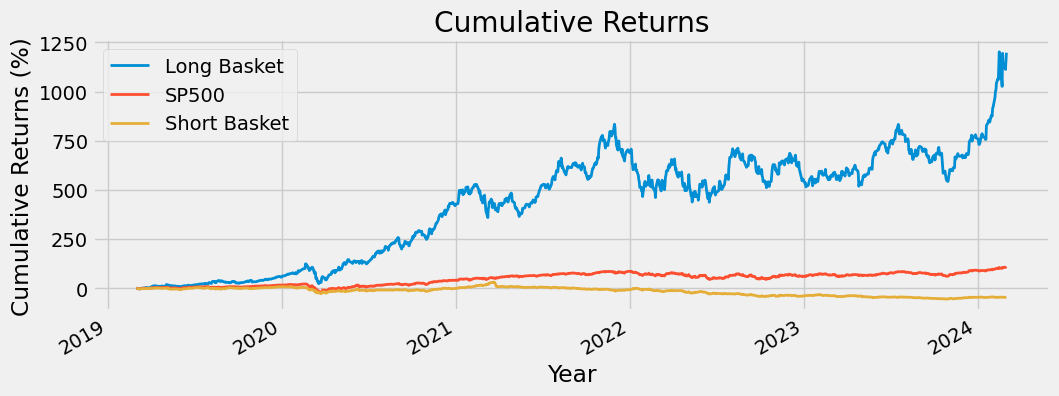

In [10]:
def calculate_cumulative_returns(dataf):
    # Calculate percentage change
    returns = dataf.pct_change()
    # Initialize the first value to 1 (i.e., no change, or 0% return)
    # This is achieved by filling the NaN values resulted from pct_change() with 0
    # and then adding 1 to convert the initial value to 1 for cumprod() calculation
    cumulative_returns = (1 + returns.fillna(0)).cumprod().mean(axis=1)*100
    # To start from 0%, subtract 100 from the entire series
    cumulative_returns = cumulative_returns - 100
    return cumulative_returns

# Calculate the cumulative returns for the SP500, long basket, and short basket
cumulative_returns = calculate_cumulative_returns(lagged_closed_price)
long_cumulative_returns = calculate_cumulative_returns(long_lagged_closed_price)
short_cumulative_returns = calculate_cumulative_returns(short_lagged_closed_price)
plt.style.use('fivethirtyeight')
plt.figure(figsize=(11,4))
long_cumulative_returns.plot(label='Long Basket', lw=2) # lw is line width
cumulative_returns.plot(label='SP500', lw =2)
short_cumulative_returns.plot(label='Short Basket', lw=2)

plt.legend()
plt.title('Cumulative Returns')
plt.xlabel('Year')
plt.ylabel('Cumulative Returns (%)')
plt.show()

## Portfolio stats -- Equally weighted (not final portfolio)

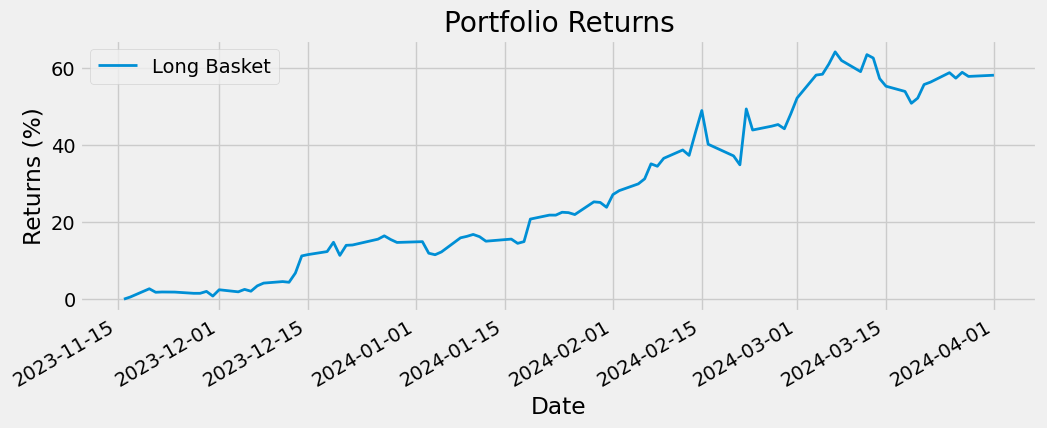

In [11]:
portfolio_returns = calculate_cumulative_returns(sp500[long_basket.index][-92:])
plt.style.use('fivethirtyeight')
plt.figure(figsize=(11,4))
portfolio_returns.plot(label='Long Basket', lw=2) 
plt.legend()
plt.title('Portfolio Returns ( Equally Weighted )')
plt.xlabel('Date')
plt.ylabel('Returns (%)')
plt.show()

In [12]:

portfolio_returns = calculate_cumulative_returns(sp500[long_basket.index][-92:])
print("Portfolio Returns from Project Completion to Current Date:")
print (portfolio_returns)

current_date = datetime.now()
project_completion_date = datetime(2023, 11, 15)

# difference between the two dates
difference_days = current_date - project_completion_date 

# number of weeks
weeks = difference_days.days // 7
print (f"Avegare Weekly Portfolio Returns from Project Completion to Current Date ({weeks} weeks): ")
print (portfolio_returns[-1]/weeks)

Portfolio Returns from Project Completion to Current Date:
Date
2023-11-16     0.000000
2023-11-17     0.553123
2023-11-20     2.694560
2023-11-21     1.782077
2023-11-22     1.858214
                ...    
2024-03-25    58.803296
2024-03-26    57.378833
2024-03-27    58.897137
2024-03-28    57.828228
2024-04-01    58.145768
Length: 92, dtype: float64
Avegare Weekly Portfolio Returns from Project Completion to Current Date (19 weeks): 
3.0603035750979055


In [13]:
print("Long Basket Cumulative Returns: Most current day")
print(long_cumulative_returns[-1])
print("Short Basket Cumulative Returns: Most current day")
print(short_cumulative_returns[-1])
print("SP500 Cumulative Returns: Most current day")
print(cumulative_returns[-1])

Long Basket Cumulative Returns: Most current day
1197.5300878781031
Short Basket Cumulative Returns: Most current day
-45.757959202984274
SP500 Cumulative Returns: Most current day
110.00495039989636


In [14]:
current_date = datetime.now().strftime("%Y-%m-%d")
print('As of',current_date,'Long Basket has outperformed the SP500 by', long_cumulative_returns[-1] - cumulative_returns[-1], 'percentage points')
print('As of',current_date, 'Short Basket has underperformed the SP500 by', short_cumulative_returns[-1] - cumulative_returns[-1], 'percentage points')


As of 2024-04-01 Long Basket has outperformed the SP500 by 1087.5251374782067 percentage points
As of 2024-04-01 Short Basket has underperformed the SP500 by -155.76290960288063 percentage points


## Graphing the Back Tested Cumulative Returns

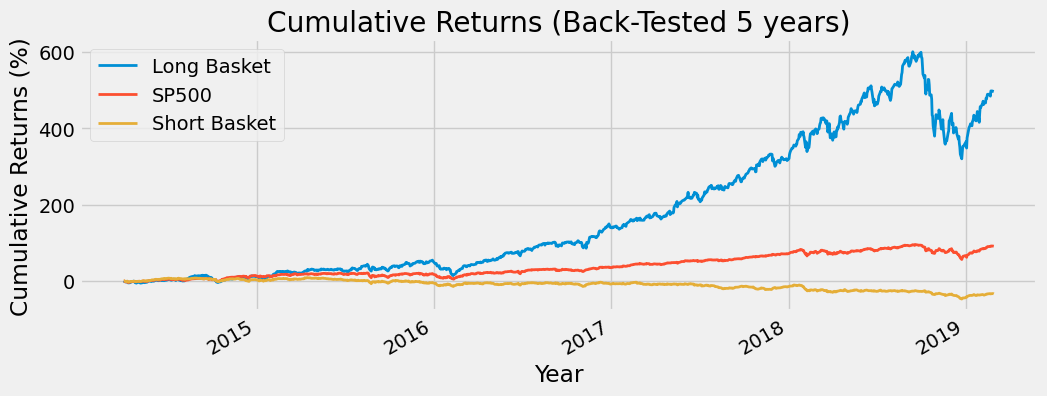

In [15]:
# Calculate the cumulative returns for the SP500, long basket, and short basket
cumulative_returns_past_5y = calculate_cumulative_returns(lagged_closed_price_past_5y)
long_cumulative_returns_past_5y = calculate_cumulative_returns(long_lagged_closed_price_past_5y)
short_cumulative_returns_past_5y = calculate_cumulative_returns(short_lagged_closed_price_past_5y)
plt.style.use('fivethirtyeight')
plt.figure(figsize=(11,4))
long_cumulative_returns_past_5y.plot(label='Long Basket', lw=2) # lw is line width
cumulative_returns_past_5y.plot(label='SP500', lw =2)
short_cumulative_returns_past_5y.plot(label='Short Basket', lw=2)

plt.legend()
plt.title('Cumulative Returns (Back-Tested 5 years)')
plt.xlabel('Year')
plt.ylabel('Cumulative Returns (%)')
plt.show()

## Monthly Potfolio Returns

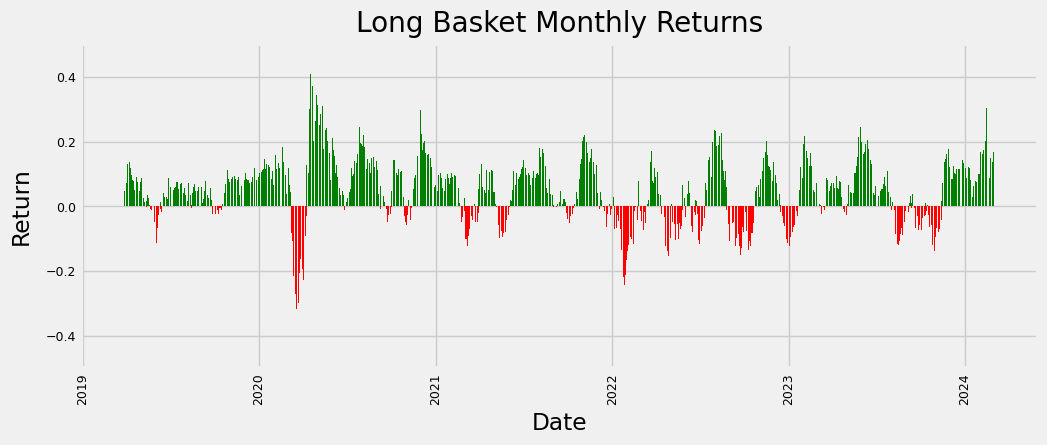

In [16]:
# Calculate 20-day returns, take the mean, drop NaNs
long_monthly_returns = long_lagged_closed_price.pct_change(20).mean(axis=1).dropna(how='all')
xdata = long_monthly_returns.index
ydata = long_monthly_returns.values
xdata = [datetime.strptime(str(x), '%Y-%m-%d %H:%M:%S') for x in xdata]

# Plot the bar chart
plt.style.use('fivethirtyeight')
plt.figure(figsize=(11,4))
plt.bar(xdata, ydata, color=['r' if m < 0 else 'g' for m in long_monthly_returns], width=1.3)

# Customize the plot
plt.tick_params(axis='both', labelsize=9)
plt.xticks(rotation=90)
plt.ylim(-0.5, 0.5) 
plt.ylabel('Return', labelpad=9)
plt.xlabel('Date', labelpad=5)
plt.title('Long Basket Monthly Returns', pad=9)
plt.show()

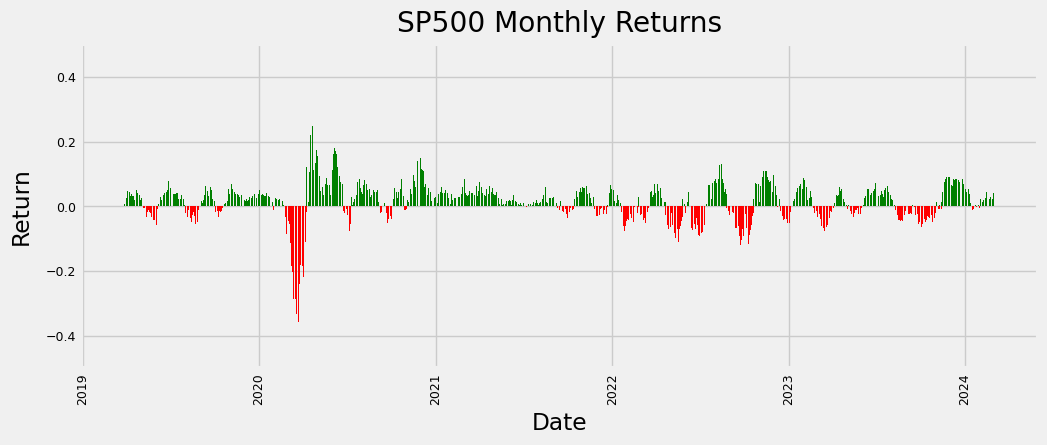

In [17]:
# Calculate 20-day returns, take the mean, drop NaNs
monthly_returns = lagged_closed_price.pct_change(20).mean(axis=1).dropna(how='all')
xdata = monthly_returns.index
ydata = monthly_returns.values
xdata = [datetime.strptime(str(x), '%Y-%m-%d %H:%M:%S') for x in xdata]

# Plot the bar chart
plt.style.use('fivethirtyeight')
plt.figure(figsize=(11,4))
plt.bar(xdata, ydata, color=['r' if m < 0 else 'g' for m in monthly_returns], width=1.3)

# Customize the plot
plt.tick_params(axis='both', labelsize=9)
plt.xticks(rotation=90)
plt.ylim(-0.5, 0.5) 
plt.ylabel('Return', labelpad=9)
plt.xlabel('Date', labelpad=5)
plt.title('SP500 Monthly Returns', pad=9)
plt.show()

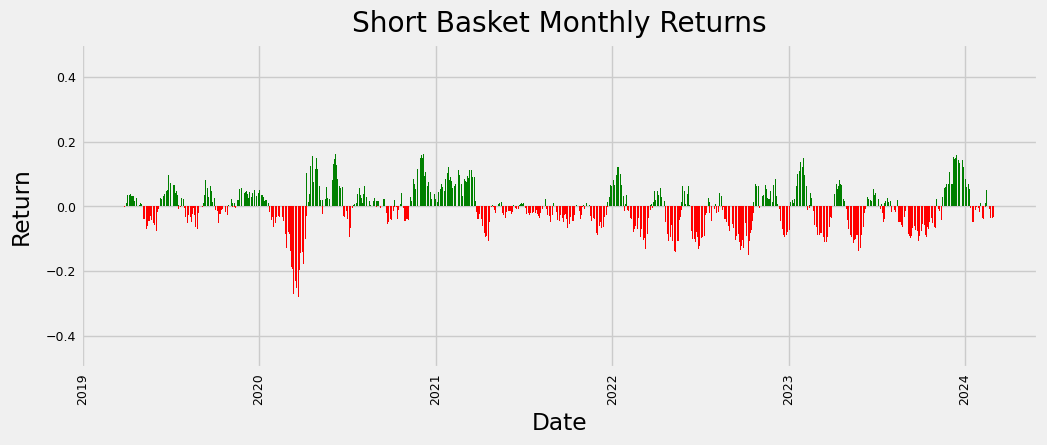

In [18]:
# Calculate 20-day returns, take the mean, drop NaNs
short_monthly_returns = short_lagged_closed_price.pct_change(20).mean(axis=1).dropna(how='all')
xdata = short_monthly_returns.index
ydata = short_monthly_returns.values
xdata = [datetime.strptime(str(x), '%Y-%m-%d %H:%M:%S') for x in xdata]

# Plot the bar chart
plt.style.use('fivethirtyeight')
plt.figure(figsize=(11,4))
plt.bar(xdata, ydata, color=['r' if m < 0 else 'g' for m in short_monthly_returns], width=1.3)

# Customize the plot
plt.tick_params(axis='both', labelsize=9)
plt.xticks(rotation=90)
plt.ylim(-0.5, 0.5) 
plt.ylabel('Return', labelpad=9)
plt.xlabel('Date', labelpad=5)
plt.title('Short Basket Monthly Returns', pad=9)
plt.show()

## Portfolio weights : 
#### My Efficient Frontier Program takes a basket of stocks and simulates over 200,000 times to find the arrangement of stock weights for our portfolio, that will return the highest earnings over risk-level.
#### You can find this program in the directory labeled Efficient_Frontier


# Portfolio weights
## Imported class from Efficient Frontier notebook
### It runs a monte-carlo simulation to find the optimal weight based on a high return to risk ratio.

In [19]:
%%capture 
import os
import sys

# Getting the directory for the efficient frontier module: 
current_dir = os.getcwd()[:-17] # slicing out the last 14 characters (current directory)
target_dir = current_dir + 'Efficient-Frontier'

# Add the directory containing the module to the Python path
sys.path.insert(0, target_dir)

from Efficient_Frontier import EfficientFrontier

"""
Im using %%capture to suppress the output of the cell.
"""

In [20]:
ef = EfficientFrontier(sp500[long_basket.index])
print('Annual Returns: Long Basket')
ef.calculate_portfolio() #Printing Annual Returns

Annual Returns: Long Basket
Ticker
TSLA    1.393622
MRNA    1.592819
NVDA    1.637919
SMCI    1.575327
NVR     1.240887
ENPH    1.588223
CMG     1.218184
BLDR    1.440965
AMD     1.544007
AZO     1.209266
dtype: float64


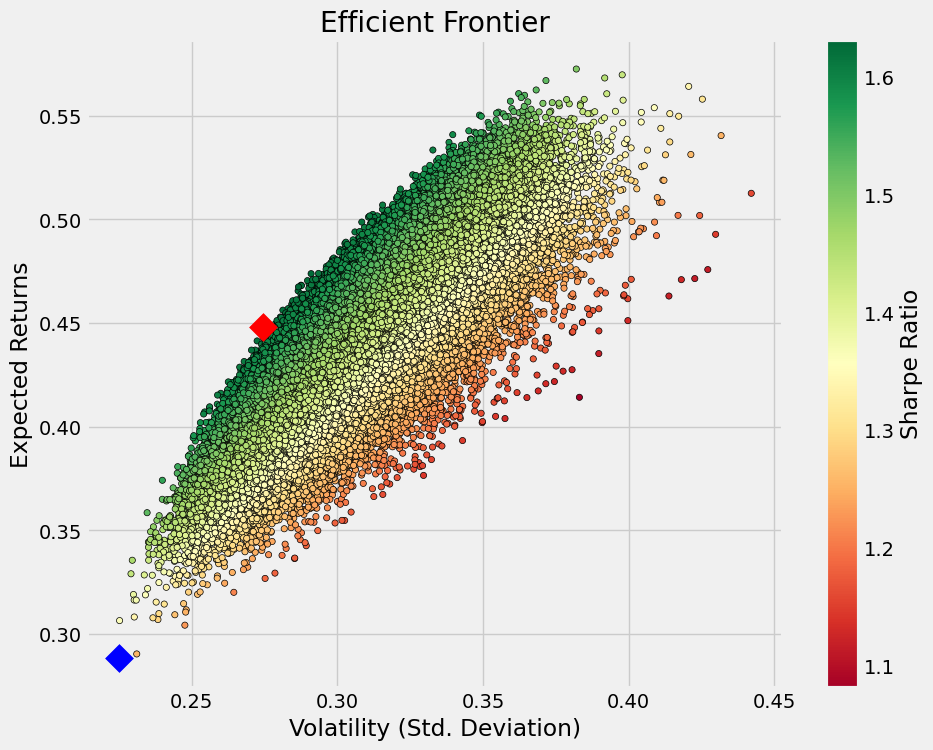

In [21]:
ef.plot_frontier() # Visualizes the simulations for our Long Basket portfolio
# With each dot representing a different portfolio, and the curve of the spread representing the efficient frontier

In [22]:
ef.get_optimal_portfolio()

              Minimum Risk Adjusted Values  Max Risk Adjusted Values
Returns                           0.288348                  0.447905
Volatility                        0.224842                  0.274450
Sharpe Ratio                      1.282448                  1.632008
TSLA Weight                       0.025823                  0.041444
MRNA Weight                       0.054518                  0.136190
NVDA Weight                       0.025910                  0.234129
SMCI Weight                       0.018101                  0.110318
NVR Weight                        0.322323                  0.112652
ENPH Weight                       0.025413                  0.034265
CMG Weight                        0.253674                  0.015259
BLDR Weight                       0.016284                  0.042795
AMD Weight                        0.029338                  0.034119
AZO Weight                        0.228615                  0.238831


## Maximizing returns with our updated weights:

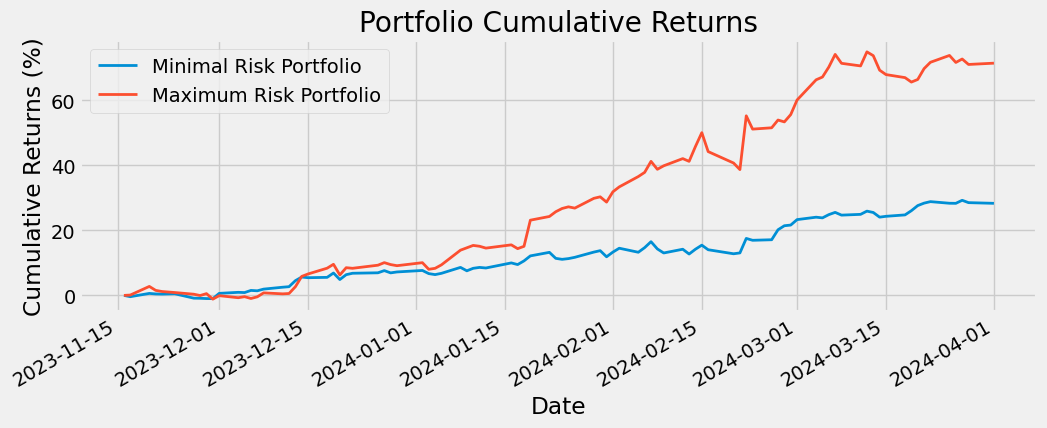

In [23]:

weights_minimal_risk = {
    'TSLA': 0.051118, 'MRNA': 0.101076, 'NVDA': 0.032128, 'SMCI': 0.010970,
    'NVR': 0.293823, 'ENPH': 0.004250, 'BLDR': 0.002243, 'CMG': 0.080609,
    'AZO': 0.377251, 'AMD': 0.046532
}

weights_maximum_risk = {
    'TSLA': 0.013270, 'MRNA': 0.155588, 'NVDA': 0.250389, 'SMCI': 0.150165,
    'NVR': 0.022550, 'ENPH': 0.073423, 'BLDR': 0.019092, 'CMG': 0.022661,
    'AZO': 0.244763, 'AMD': 0.048099
}

# Calculate daily portfolio returns for both scenarios
portfolio_returns_minimal_risk = (sp500[long_basket.index][-92:].pct_change() * pd.Series(weights_minimal_risk)).sum(axis=1)
portfolio_returns_maximum_risk = (sp500[long_basket.index][-92:].pct_change() * pd.Series(weights_maximum_risk)).sum(axis=1)

# Calculate cumulative returns to see the overall performance
cumulative_returns_minimal_risk = ((1 + portfolio_returns_minimal_risk).cumprod() - 1)*100
cumulative_returns_maximum_risk = ((1 + portfolio_returns_maximum_risk).cumprod() - 1)*100

# If you want to plot these
plt.figure(figsize=(11, 4))
cumulative_returns_minimal_risk.plot(label='Minimal Risk Portfolio', lw=2)
cumulative_returns_maximum_risk.plot(label='Maximum Risk Portfolio', lw=2)
plt.legend()
plt.title('Portfolio Cumulative Returns')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns (%)')
plt.show()

In [24]:
print ("Max Risk portfolio returns:")
print (cumulative_returns_maximum_risk)
print ("Min Risk portfolio returns:")
print (cumulative_returns_minimal_risk)

print (f"Avegare Weekly Max Risk Portfolio Returns from Project Completion to Current Date ({weeks} weeks): ")
print (cumulative_returns_maximum_risk[-1]/weeks)

print (f"Avegare Weekly Min Risk Portfolio Returns from Project Completion to Current Date ({weeks} weeks): ")
print (cumulative_returns_minimal_risk[-1]/weeks)



Max Risk portfolio returns:
Date
2023-11-16     0.000000
2023-11-17     0.110744
2023-11-20     2.760303
2023-11-21     1.547251
2023-11-22     1.193113
                ...    
2024-03-25    73.774103
2024-03-26    71.620688
2024-03-27    72.679326
2024-03-28    71.003531
2024-04-01    71.401171
Length: 92, dtype: float64
Min Risk portfolio returns:
Date
2023-11-16     0.000000
2023-11-17    -0.393507
2023-11-20     0.612144
2023-11-21     0.452038
2023-11-22     0.404814
                ...    
2024-03-25    28.331459
2024-03-26    28.308445
2024-03-27    29.242735
2024-03-28    28.518317
2024-04-01    28.307222
Length: 92, dtype: float64
Avegare Weekly Max Risk Portfolio Returns from Project Completion to Current Date (19 weeks): 
3.7579563819766473
Avegare Weekly Min Risk Portfolio Returns from Project Completion to Current Date (19 weeks): 
1.4898537995653485
